In [1]:
import os
import mne
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [11]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [4]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [5]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

In [6]:
def augment_data(data, new_data_len, data_gap):
    new_data_indices = []
    data_len = len(data)
    data_start_index, data_end_index = 0, new_data_len
    while data_end_index <= data_len:
        new_data_indices.append(list(range(data_start_index, data_end_index)))
        data_start_index += data_gap
        data_end_index += data_gap
    new_data = [data[data_indices] for data_indices in new_data_indices]
    return new_data

In [ ]:
def add_noise(data, std_dev, mean = 0):
    noise = np.random.normal(mean, std_dev, size = data.shape)
    new_data = data + noise
    return new_data

In [7]:
subject_name = 'SubjectG'
data, labels = retrieve_data(subject_name)
labels = tf.keras.utils.to_categorical(labels, num_classes = len(np.unique(labels)))

In [8]:
data_length, data_gap = 150, 10
copy_data = data.copy()
epoch_data, epoch_label = [], []
for index, data in enumerate(copy_data):
    augmented_data = []
    for channel_index in range(data.shape[0]):
        augmented_data.append(augment_data(data[channel_index, :, 0], data_length, data_gap))
    augmented_data = np.array(augmented_data)
    for data_index in range(augmented_data.shape[1]):
        new_data = augmented_data[:, data_index]
        new_label = labels[index]
        epoch_data.append(new_data)
        epoch_label.append(new_label)
epoch_data = np.array(epoch_data)
epoch_label = np.array(epoch_label)

In [9]:
print('Data shape after sliding window: {}'.format(epoch_data.shape))

Data shape after sliding window: (5703, 21, 150)


In [ ]:
def create_cnn(input_shape, optimizer = None, conv_init = None, dense_init = None, act_fx = 'relu'):
    if conv_init is None:
        conv1_init = tf.keras.initializers.GlorotUniform(42)
        conv2_init = tf.keras.initializers.GlorotUniform(42)
    else:
        conv1_init = conv_init
        conv1_init.seed = 42
        conv2_init = conv_init
        conv2_init.seed = 42
    if dense_init is None:
        dense1_init = tf.keras.initializers.GlorotUniform(24)
        dense2_init = tf.keras.initializers.GlorotUniform(24)
    else:
        dense1_init = dense_init
        dense1_init.seed = 24
        dense2_init = dense_init
        dense2_init.seed = 24
    if act_fx == 'relu' or act_fx == 'selu' or act_fx == 'elu':
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                   activation = act_fx, kernel_initializer = conv1_init),
            tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = act_fx,
                   kernel_initializer = conv2_init),
            tf.keras.layers.MaxPooling2D(padding = 'same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units = 128, activation = act_fx, kernel_initializer = dense1_init),
            tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
        ])
    else:
        if act_fx == 'prelu':
            model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                                       kernel_initializer = conv1_init),
                tf.keras.layers.PReLU(),
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), kernel_initializer = conv2_init),
                tf.keras.layers.PReLU(),
                tf.keras.layers.MaxPooling2D(padding = 'same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units = 128, kernel_initializer = dense1_init),
                tf.keras.layers.PReLU(),
                tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
            ])
        else:
            model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                                       kernel_initializer = conv1_init),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), kernel_initializer = conv2_init),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.MaxPooling2D(padding = 'same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units = 128, kernel_initializer = dense1_init),
                tf.keras.layers.LeakyReLU(),
                tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
            ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [ ]:
test_ratio = 0.1
shuffled_index = list(range(len(epoch_data)))
np.random.shuffle(shuffled_index)
train_size = round((1 - test_ratio) * len(epoch_data))
train_index, test_index = shuffled_index[:train_size], shuffled_index[train_size:]
epoch_data_train, epoch_data_test = epoch_data[train_index], epoch_data[test_index]
epoch_label_train, epoch_label_test = epoch_label[train_index], epoch_label[test_index]

In [ ]:
print(epoch_data_train.shape)
print(epoch_data_test.shape)
print(epoch_label_train.shape)
print(epoch_label_test.shape)

In [ ]:
epoch_data_train, epoch_data_test, epoch_label_train, epoch_label_test = train_test_split(epoch_data, epoch_label,
                                                                                          test_size = 0.1,
                                                                                          random_state = 42,
                                                                                          stratify = epoch_label)
print('Train data size: {}'.format(epoch_data_train.shape))
print('Test data size: {}'.format(epoch_data_test.shape))

In [ ]:
std_devs = [0.3, 0.4]
copy_data = epoch_data_train.copy()
epoch_data_train, epoch_label_train = list(epoch_data_train), list(epoch_label_train)
for index, data in enumerate(copy_data):
    for dev in std_devs:
        epoch_data_train.append(add_noise(data, std_dev = dev))
        epoch_label_train.append(epoch_label_train[index])
epoch_data_train, epoch_label_train = np.array(epoch_data_train), np.array(epoch_label_train)
print('Train data after noise addition: {}'.format(epoch_data_train.shape))

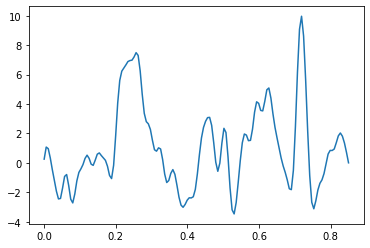

In [10]:
plt.plot(np.linspace(0, 0.85, num = len(epoch_data[1][4, :])), epoch_data[0][5, :])
plt.show()

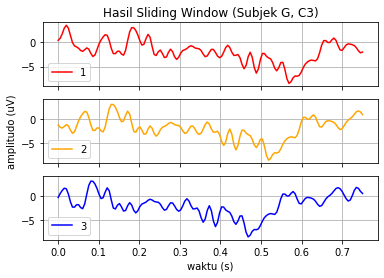

In [21]:
test_data = augment_data(epoch_data[0][4, :], 150, 10)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = 'all', sharey = 'all', figsize = (6, 4))
ax1.plot(np.linspace(0, 0.75, num = len(test_data[0])), test_data[0], color = 'red')
ax1.set_title('Hasil Sliding Window (Subjek G, C3)')
ax2.set_ylabel('amplitudo (uV)')
ax1.legend(['1'])
ax1.grid(True)
ax2.plot(np.linspace(0, 0.75, num = len(test_data[1])), test_data[1], color = 'orange')
ax2.set_ylabel('amplitudo (uV)')
ax2.legend(['2'])
ax2.grid(True)
ax3.plot(np.linspace(0, 0.75, num = len(test_data[2])), test_data[2], color = 'blue')
ax3.set_xlabel('waktu (s)')
ax2.set_ylabel('amplitudo (uV)')
ax3.legend(['3'])
ax3.grid(True)

In [ ]:
kernel_inits = [tf.keras.initializers.GlorotUniform, tf.keras.initializers.GlorotNormal]
act_functions = ['relu', 'elu', 'selu', 'prelu', 'leaky_relu']

In [ ]:
losses = []
parameter_list = []
acc_scores, prec_scores, rec_scores = [], [], []
epoch_data_train = tf.expand_dims(epoch_data_train, axis = -1)
epoch_data_test = tf.expand_dims(epoch_data_test, axis = -1)
input_shape = (epoch_data_train.shape[1], epoch_data_train.shape[2], epoch_data_train.shape[3])
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)
for kernel_init in kernel_inits:
    for function in act_functions:
        model = create_cnn(input_shape = input_shape, conv_init = kernel_init, dense_init = kernel_init,
                           act_fx = function)
        history = model.fit(epoch_data_train, epoch_label_train, batch_size = 16, epochs = 15, 
                            validation_data = (epoch_data_test, epoch_label_test), callbacks = [early_stop])
        loss, acc = model.evaluate(epoch_data_test, epoch_label_test)
        predictions = model.predict(epoch_data_test)
        predictions = np.array([np.argmax(prediction) for prediction in predictions])
        real_labels = np.array([np.argmax(label) for label in epoch_label_test])
        losses.append(loss)
        acc_scores.append(acc)
        prec_scores.append(precision_score(real_labels, predictions, average = 'weighted'))
        rec_scores.append(recall_score(real_labels, predictions, average = 'weighted'))
        parameter_list.append((kernel_inits.index(kernel_init), function))

In [ ]:
# predictions = model.predict(epoch_data_test)
# predictions = np.array([np.argmax(prediction) for prediction in predictions])
# real_label = np.array([np.argmax(label) for label in epoch_label_test])
# print('Accuracy: {}'.format(accuracy_score(real_label, predictions)))
# print('Precision: {}'.format(precision_score(real_label, predictions, average = 'weighted')))
# print('Recall: {}'.format(recall_score(real_label, predictions, average = 'weighted')))

In [ ]:
# predictions = model.predict(epoch_data_test)
# predictions = np.array([np.argmax(prediction) for prediction in predictions])
# real_label = np.array([np.argmax(label) for label in epoch_label_test])
# print('Accuracy: {}'.format(accuracy_score(real_label, predictions)))
# print('Precision: {}'.format(precision_score(real_label, predictions, average = 'weighted')))
# print('Recall: {}'.format(recall_score(real_label, predictions, average = 'weighted')))

In [ ]:
# predictions = model.predict(epoch_data_test)
# predictions = np.array([np.argmax(prediction) for prediction in predictions])
# real_label = np.array([np.argmax(label) for label in epoch_label_test])
# print('Accuracy: {}'.format(accuracy_score(real_label, predictions)))
# print('Precision: {}'.format(precision_score(real_label, predictions, average = 'weighted')))
# print('Recall: {}'.format(recall_score(real_label, predictions, average = 'weighted')))

In [ ]:
df = pd.DataFrame({'Parameter': parameter_list, 'Accuracy': acc_scores, 'Precision': prec_scores,
                   'Recall': rec_scores})
df

In [ ]:
df.to_csv('{}_HT.csv'.format(subject_name))

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc = 'upper left')
# plt.savefig('cnn_accuracy.png', facecolor = 'w', edgecolor = 'w')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc = 'upper left')
# plt.savefig('cnn_loss.png', facecolor = 'w', edgecolor = 'w')
# plt.show()